<a href="https://colab.research.google.com/github/mdkamrulhasan/machine_learning_concepts/blob/master/notebooks/supervised/image_classification_100c_cnn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training an image classifier
We will do the following steps in order:



1.   Load and normalize the training and test datasets
2.   Define a Convolutional Neural Network
3.   Define a loss function
4.   Train the network on the training data
5.   Test the network on the training data
6.   Making predictions for the test data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
import os
import pickle

## 1. Load data

In [3]:
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/data/fall-2025-ass3'# 'Your Google Drive Path where you uploaded train_X_y.pkl and test_X.pkl'

Mounted at /content/drive


In [4]:
# Training data
with open(os.path.join(base_path, 'train_X_y.pkl'),'rb') as f:
    X_train, y_train = pickle.load(f)

# Test data
with open(os.path.join(base_path, 'test_X.pkl'),'rb') as f:
    X_test = pickle.load(f)

In [5]:
# Reshaping data matrices
X_train = np.transpose(X_train.astype(int), (0, 3, 1, 2))
X_test= np.transpose(X_test.astype(int), (0, 3, 1, 2))
X_train.shape

(30000, 3, 24, 24)

In [6]:

# 1. Define a custom Data Loader
class NumpyDataset(Dataset):
    def __init__(self, X, Y=None, transform=None):
        self.X = torch.from_numpy(X).float()  # convert to float tensor
        if Y is not None:
          self.Y = torch.from_numpy(Y).long()   # convert to long tensor
        else:
          self.Y = torch.from_numpy(np.zeros(len(self.X))).long()
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]

        if self.transform:
            x = self.transform(x)
        return x, y



In [7]:
# Data Loaders + Batch Size
transform = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10


train_dataset = NumpyDataset(X_train, y_train.flatten(), transform=transform)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = NumpyDataset(X_test, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### Display some images

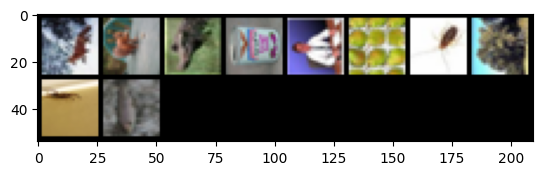

In [8]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy().astype(int)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))


##2. Define a CNN model architecture

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net24x24(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 3 * 3, 120)  # updated input size
        self.fc2 = nn.Linear(120, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# CNN model instantiation
net = Net24x24()

In [11]:
from torchsummary import summary
summary(net, input_size=(3, 24, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 20, 20]             456
         MaxPool2d-2            [-1, 6, 10, 10]               0
            Conv2d-3             [-1, 16, 6, 6]           2,416
         MaxPool2d-4             [-1, 16, 3, 3]               0
            Linear-5                  [-1, 120]          17,400
            Linear-6                  [-1, 100]          12,100
Total params: 32,372
Trainable params: 32,372
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.12
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


##3. Define a Loss function

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(net.parameters(),
                       lr=0.0001, betas=(0.9, 0.999),
                       eps=1e-08, weight_decay=0.01)

##4. Model/network training

In [13]:
NB_EPOCHS = 50

for epoch in range(NB_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 4.780
[2,  2000] loss: 4.155
[3,  2000] loss: 3.854
[4,  2000] loss: 3.658
[5,  2000] loss: 3.496
[6,  2000] loss: 3.367
[7,  2000] loss: 3.263
[8,  2000] loss: 3.178
[9,  2000] loss: 3.125
[10,  2000] loss: 3.052
[11,  2000] loss: 3.006
[12,  2000] loss: 2.967
[13,  2000] loss: 2.929
[14,  2000] loss: 2.902
[15,  2000] loss: 2.849
[16,  2000] loss: 2.821
[17,  2000] loss: 2.785
[18,  2000] loss: 2.771
[19,  2000] loss: 2.745
[20,  2000] loss: 2.706
[21,  2000] loss: 2.697
[22,  2000] loss: 2.671
[23,  2000] loss: 2.652
[24,  2000] loss: 2.622
[25,  2000] loss: 2.614
[26,  2000] loss: 2.603
[27,  2000] loss: 2.591
[28,  2000] loss: 2.564
[29,  2000] loss: 2.553
[30,  2000] loss: 2.533
[31,  2000] loss: 2.520
[32,  2000] loss: 2.505
[33,  2000] loss: 2.493
[34,  2000] loss: 2.481
[35,  2000] loss: 2.470
[36,  2000] loss: 2.455
[37,  2000] loss: 2.435
[38,  2000] loss: 2.437
[39,  2000] loss: 2.426
[40,  2000] loss: 2.408
[41,  2000] loss: 2.400
[42,  2000] loss: 2.392
[

### Save the model for future reference

In [14]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Load the model

In [15]:
# net = Net()
net = Net24x24()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

## 5. Test the network on the training data

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
output_labels = []
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        output_labels += predicted.tolist()
        # total += labels.size(0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 30000 training images: {100 * correct // total} %')

Accuracy of the network on the 30000 training images: 41 %


In [15]:
correct, len(output_labels), total

(6094, 30000, 30000)

##6. Test the network on test data

In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
output_labels = []
with torch.no_grad():
    for data in testloader:
        images, _ = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        output_labels += predicted.tolist()
        total += labels.size(0)

In [18]:
# Pack results in a pandas dataframe
import pandas as pd
test_predictions = pd.DataFrame({
    'rowId': range(0, len(output_labels)),
    'label': output_labels})

In [19]:
test_predictions.head()

,rowId,label
0,0,79
1,1,13
2,2,30
3,3,77
4,4,61


In [20]:
# Exporting resluts
test_predictions.to_csv(os.path.join(base_path, 'my_cnn_results.csv'), index=False)